# Plot of generalization error with spectral adversarial regularization

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [2]:
%load_ext autoreload
%autoreload 2

import time
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from spectral_adversarial_regularization import dl_utils

%matplotlib inline

In [3]:
from spectral_adversarial_regularization.models import *
from get_cifar10 import get_cifar10_dataset

# Load dataset
n_samps = 50000
num_classes = 10

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}

In [3]:
def make_plots(arch_name, wd, all_tr_acc, all_va_acc):
    """Generate plot of final train accuracy, final test accuracy v regularization constant"""
    
    inds = np.argsort(wd)
    wd = np.array(wd)[inds]
    true_tr_acc = all_tr_acc['true'][-len(wd):][inds]
    true_va_acc = all_va_acc['true'][-len(wd):][inds]
    rand_tr_acc = all_tr_acc['rand'][-len(wd):][inds]
    rand_va_acc = all_va_acc['rand'][-len(wd):][inds]
    
    print('For regular %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][0], all_va_acc['true'][0],
            (1-all_va_acc['true'][0])-(1-all_tr_acc['true'][0])))

    print('For fully sn %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][1], all_va_acc['true'][1],
            (1-all_va_acc['true'][1])-(1-all_tr_acc['true'][1])))
    
    print('For sn (except for last layer also no wd) %s, tr acc: %.3f, va acc: %.3f, generalization error: %.3f'
          %(arch_name, all_tr_acc['true'][2], all_va_acc['true'][2],
            (1-all_va_acc['true'][2])-(1-all_tr_acc['true'][2])))

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(wd, true_tr_acc, label='true, training')
    plt.plot(wd, true_va_acc, label='true, validation')
    plt.plot(wd, rand_tr_acc, label='random, training')
    plt.plot(wd, rand_va_acc, label='random, validation')
    plt.xlabel('weight decay')
    plt.xscale('log')
    plt.ylabel('accuracy')
#     plt.ylim(-0.1, 1.1)
    plt.title(arch_name)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(wd, (1-true_va_acc)-(1-true_tr_acc), label='true')
    plt.plot(wd, (1-rand_va_acc)-(1-rand_tr_acc), label='random')
    plt.xlabel('weight decay')
    plt.xscale('log')
    plt.ylabel('generalization error')
#     plt.ylim(-0.1, 1.1)
    plt.title(arch_name)
    plt.legend()
    plt.grid()

    plt.show()

def compare_performance(main_dir, verbose=True):
    """Recover training and validation accuracies"""
    
    arch_name = main_dir.split('_')[-1]

    all_tr_acc = {'true':[], 'rand':[]}
    all_va_acc = {'true':[], 'rand':[]}
    wd = []

    if verbose: start = time.time()

    for i, f in enumerate(os.listdir(main_dir)):
        if 'wd' in f and i%2 == 0:
            wd.append(float(f.split('wd')[1]))

        save_dir = os.path.join(main_dir, f)
        tr_acc, va_acc = dl_utils.extract_train_valid_tensorboard(save_dir, only_final_value=True)
        all_tr_acc[f.split('_')[1]].append(tr_acc)
        all_va_acc[f.split('_')[1]].append(va_acc)
        if verbose: 
            print('%s done. (%.2f s elapsed)'%(f, time.time()-start))

    for i in all_tr_acc:
        all_tr_acc[i] = np.array(all_tr_acc[i])
        all_va_acc[i] = np.array(all_va_acc[i])
    
    wd = np.array(wd)
    
    return all_tr_acc, all_va_acc, wd

### Spectral normalization using Miyato et al.'s method

In [4]:
# Takes about 11.5 minutes to run for mlp1, mlp3, alexnet, inception, vgg
results = {}
for f in os.listdir('.'):
    if 'save_weights' in f and 'tightsn' not in f and 'small' not in f and 'prototyping' not in f:
        arch_name = f.split('_')[-1]
        results[arch_name] = compare_performance(f, verbose=True)

For regular alexnet, tr acc: 1.000, va acc: 0.778, generalization error: 0.222
For fully sn alexnet, tr acc: 0.990, va acc: 0.766, generalization error: 0.224
For sn (except for last layer also no wd) alexnet, tr acc: 1.000, va acc: 0.792, generalization error: 0.208


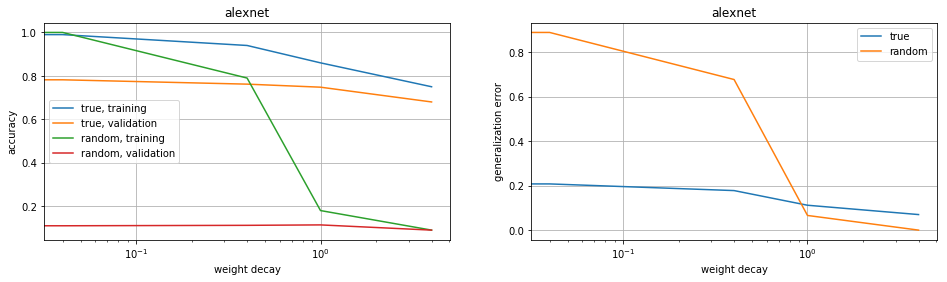

For regular inception, tr acc: 1.000, va acc: 0.864, generalization error: 0.136
For fully sn inception, tr acc: 1.000, va acc: 0.852, generalization error: 0.148
For sn (except for last layer also no wd) inception, tr acc: 1.000, va acc: 0.854, generalization error: 0.146


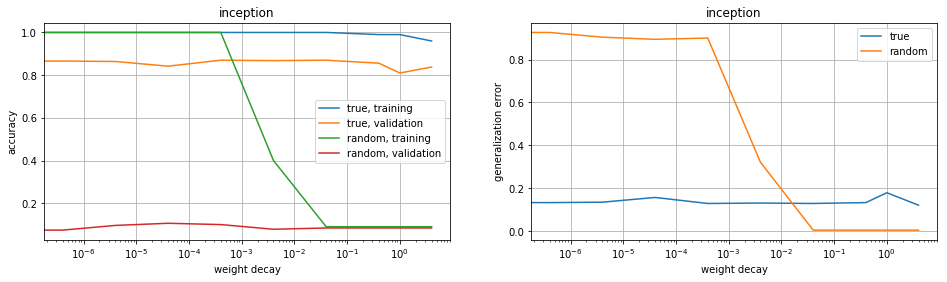

For regular mlp1, tr acc: 0.950, va acc: 0.480, generalization error: 0.470
For fully sn mlp1, tr acc: 0.760, va acc: 0.508, generalization error: 0.252
For sn (except for last layer also no wd) mlp1, tr acc: 1.000, va acc: 0.490, generalization error: 0.510


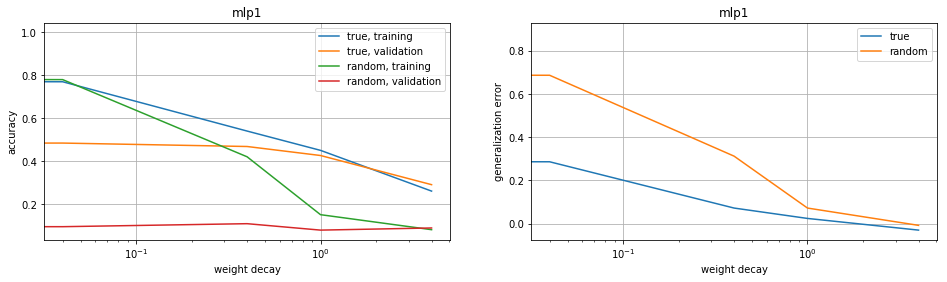

For regular mlp3, tr acc: 1.000, va acc: 0.516, generalization error: 0.484
For fully sn mlp3, tr acc: 0.840, va acc: 0.542, generalization error: 0.298
For sn (except for last layer also no wd) mlp3, tr acc: 1.000, va acc: 0.502, generalization error: 0.498


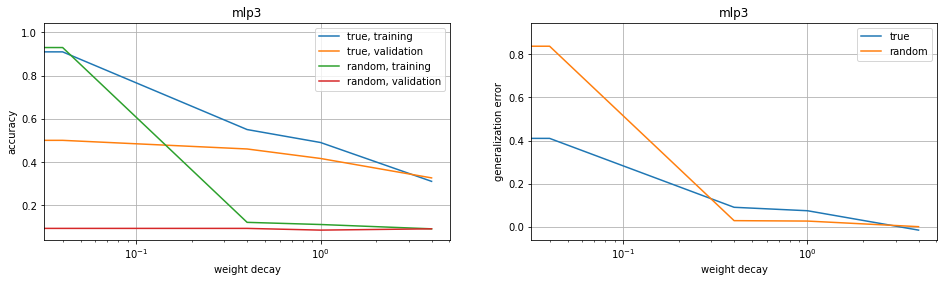

For regular vgg, tr acc: 1.000, va acc: 0.796, generalization error: 0.204
For fully sn vgg, tr acc: 1.000, va acc: 0.772, generalization error: 0.228
For sn (except for last layer also no wd) vgg, tr acc: 1.000, va acc: 0.790, generalization error: 0.210


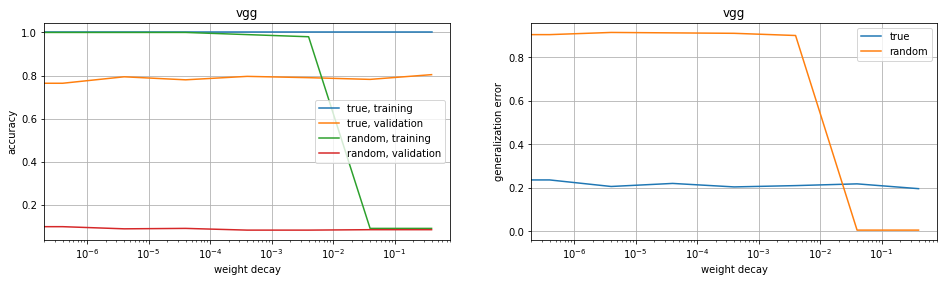

In [25]:
for arch_name in sorted(results):
    make_plots(arch_name, results[arch_name][2], results[arch_name][0], results[arch_name][1])

### Spectral normalization using our tighter method

inception_rand_sn done. (33.95 s elapsed)
inception_true_sn done. (72.53 s elapsed)
inception_rand_sar_wd0 done. (106.24 s elapsed)
inception_true_sar_wd0 done. (119.48 s elapsed)
inception_rand_sar_wd4e-05 done. (153.60 s elapsed)
inception_true_sar_wd4e-05 done. (160.08 s elapsed)
inception_rand_sar_wd0.0004 done. (183.60 s elapsed)
inception_true_sar_wd0.0004 done. (191.84 s elapsed)
inception_rand_sar_wd0.004 done. (223.26 s elapsed)
inception_true_sar_wd0.004 done. (249.61 s elapsed)
inception_rand_sar_wd0.04 done. (272.63 s elapsed)
inception_true_sar_wd0.04 done. (296.87 s elapsed)
inception_true_sar_wd0.4 done. (322.20 s elapsed)
inception_true_sar_wd4.0 done. (350.23 s elapsed)
For regular inception_tightsn, tr acc: 0.990, va acc: 0.830, generalization error: 0.160
For fully sn inception_tightsn, tr acc: 1.000, va acc: 0.840, generalization error: 0.160
For sn (except for last layer also no wd) inception_tightsn, tr acc: 1.000, va acc: 0.850, generalization error: 0.150


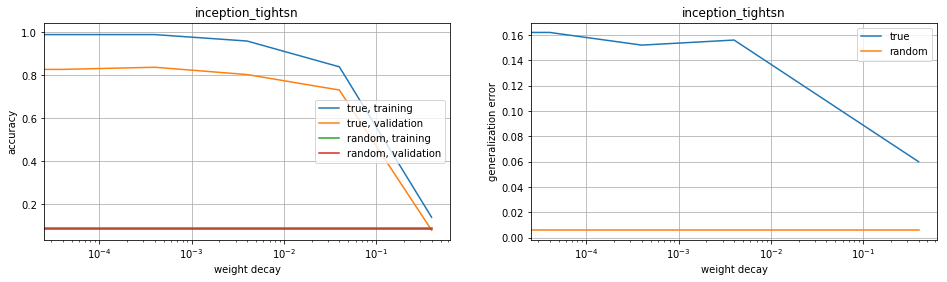

In [5]:
results = compare_performance('./save_weights_n50000_inception_tightsn/', verbose=True)
make_plots('inception_tightsn', results[2], results[0], results[1])

# Visualization of margins

as discussed in Bartlett's [paper](https://arxiv.org/pdf/1706.08498.pdf) (see Figure 2)

In [54]:
def make_margin_plots_for_all_in_dir(data, maindir, arch_d, plots_per_row=4):
    arch_name = maindir.split('_')[-1]

    start = time.time()
    
    p_count = 0

    def sort_func(fname):
        if 'wd' not in fname:
            return (0, fname)
        return (float(fname.split('wd')[1]), fname)

    for f in sorted(os.listdir(maindir), key=sort_func):
        save_dir = os.path.join(maindir, f)

        if 'rand' in f:
            arch = arch_d[f]
            rand_margins = dl_utils.get_margins(data['rand'][0], data['rand'][1], save_dir, arch=arch)
            save_dir = save_dir.replace('rand', 'true')
            true_margins = dl_utils.get_margins(data['true'][0], data['true'][1], save_dir, arch=arch)

            if p_count%plots_per_row == 0:
                plt.figure(figsize=(16, 4))
                p_count = 0
                
            plt.subplot(1, plots_per_row, p_count+1)
            dl_utils.plot_stacked_hist(rand_margins, true_margins, ['rand', 'true'])
            plt.title(f.replace('_rand', '').replace('_true', ''))
            plt.xlabel('margin')
            plt.grid()
            
            p_count += 1
            
def get_arch_d_str(maindir):
    print('arch_d = {')
    for f in os.listdir(maindir):
        if 'rand' in f:
            last_str = ''
            if '_sn' in f:
                last_str = '_sn'
            elif '_sar' in f:
                last_str = '_sar'
            else:
                last_str = ''

            print('    \''+f+'\': %s.%s%s,'
                  %(maindir.split('_')[-1], maindir.split('_')[-1], last_str))
    print('}')

### Spectral normalization using Miyato et al.'s method

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
Sanity check: accuracy is 0.99952.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Sanity check: accuracy is 0.99828.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0/checkpoints/epoch48
Sanity check: accuracy is 0.99848.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sn/checkpoints/epoch242
Sanity check: accuracy is 0.99676.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sn/checkpoints/epoch69
Sanity check: accuracy is 0.99854.
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0.04/checkpoints/epoch169
Sanity check: accuracy is 0.99608.

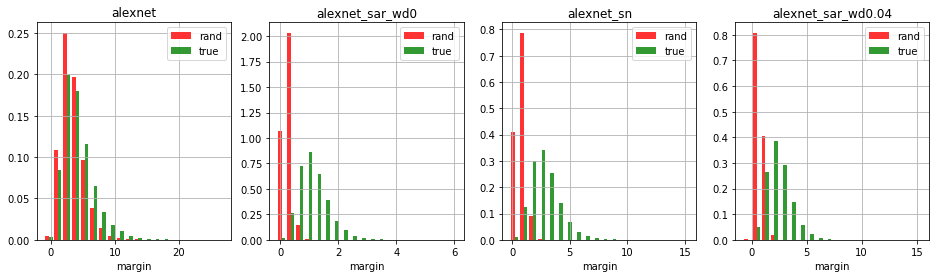

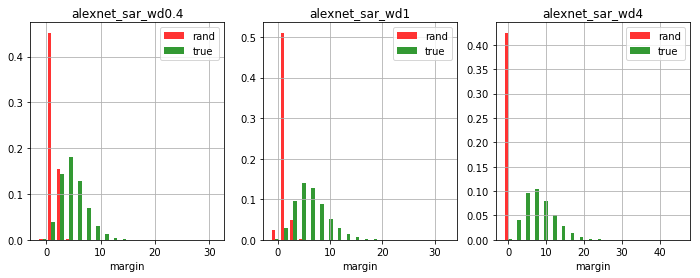

In [55]:
maindir = 'save_weights_n50000_alexnet'
# get_arch_d_str(maindir)

arch_d = {
    'alexnet_rand': alexnet.alexnet,
    'alexnet_rand_sn': alexnet.alexnet_sn,
    'alexnet_rand_sar_wd0': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.04': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.4': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd1': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd4': alexnet.alexnet_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand/checkpoints/epoch183
Sanity check: accuracy is 0.99580.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Sanity check: accuracy is 0.99626.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd0/checkpoints/epoch230
Sanity check: accuracy is 0.99912.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sar_wd0/checkpoints/epoch57
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sn/checkpoints/epoch236
Sanity check: accuracy is 0.99922.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true_sn/checkpoints/epoch76
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_rand_sar_wd4e-07/checkpoints/epoch225
San

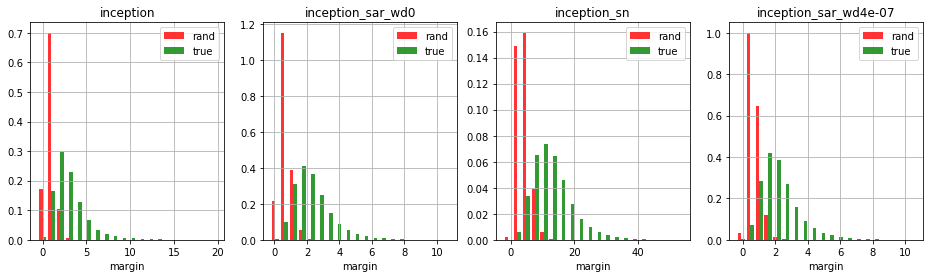

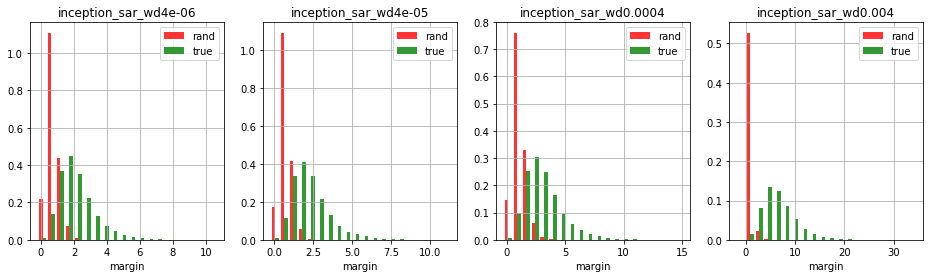

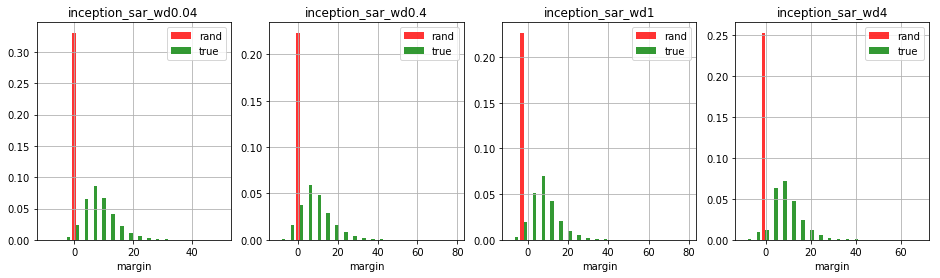

In [57]:
maindir = 'save_weights_n50000_inception'

arch_d = {
    'inception_rand': inception.inception,
    'inception_rand_sn': inception.inception_sn,
    'inception_rand_sar_wd0': inception.inception_sar,
    'inception_rand_sar_wd4e-07': inception.inception_sar,
    'inception_rand_sar_wd4e-06': inception.inception_sar,
    'inception_rand_sar_wd4e-05': inception.inception_sar,
    'inception_rand_sar_wd0.0004': inception.inception_sar,
    'inception_rand_sar_wd0.004': inception.inception_sar,
    'inception_rand_sar_wd0.04': inception.inception_sar,
    'inception_rand_sar_wd0.4': inception.inception_sar,
    'inception_rand_sar_wd1': inception.inception_sar,
    'inception_rand_sar_wd4': inception.inception_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand/checkpoints/epoch499
Sanity check: accuracy is 0.94518.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true/checkpoints/epoch499
Sanity check: accuracy is 0.95268.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd0/checkpoints/epoch77
Sanity check: accuracy is 0.98534.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd0/checkpoints/epoch42
Sanity check: accuracy is 0.90434.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sn/checkpoints/epoch499
Sanity check: accuracy is 0.73704.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
Sanity check: accuracy is 0.85748.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_rand_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.77992.
INFO:tensorflow:Restoring parameters f

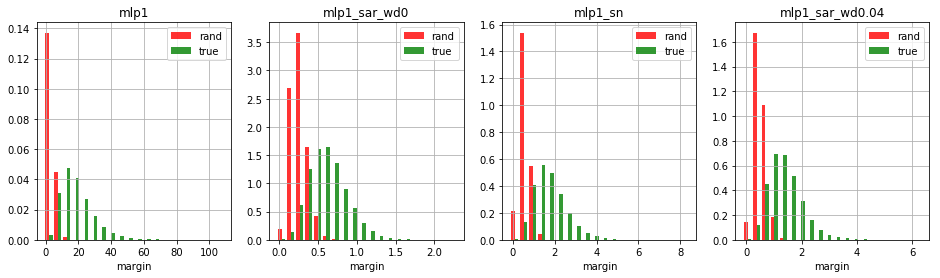

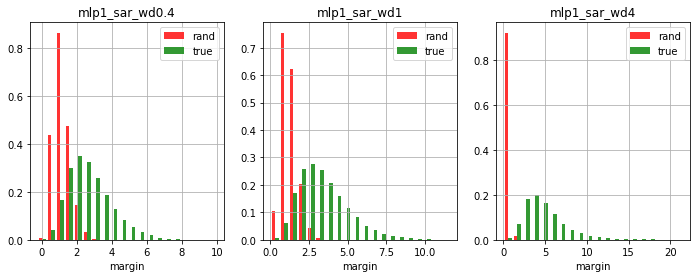

In [58]:
maindir = 'save_weights_n50000_mlp1'

arch_d = {
    'mlp1_rand': mlp.mlp1,
    'mlp1_rand_sn': mlp.mlp1_sn,
    'mlp1_rand_sar_wd0': mlp.mlp1_sar,
    'mlp1_rand_sar_wd0.04': mlp.mlp1_sar,
    'mlp1_rand_sar_wd0.4': mlp.mlp1_sar,
    'mlp1_rand_sar_wd1': mlp.mlp1_sar,
    'mlp1_rand_sar_wd4': mlp.mlp1_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand/checkpoints/epoch499
Sanity check: accuracy is 0.72398.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true/checkpoints/epoch52
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd0/checkpoints/epoch53
Sanity check: accuracy is 0.98344.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd0/checkpoints/epoch37
Sanity check: accuracy is 0.98320.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sn/checkpoints/epoch499
Sanity check: accuracy is 0.86460.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sn/checkpoints/epoch499
Sanity check: accuracy is 0.90598.
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_rand_sar_wd0.04/checkpoints/epoch499
Sanity check: accuracy is 0.90966.
INFO:tensorflow:Restoring parameters fr

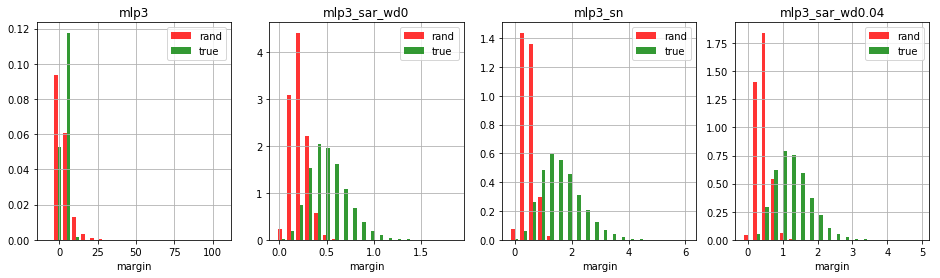

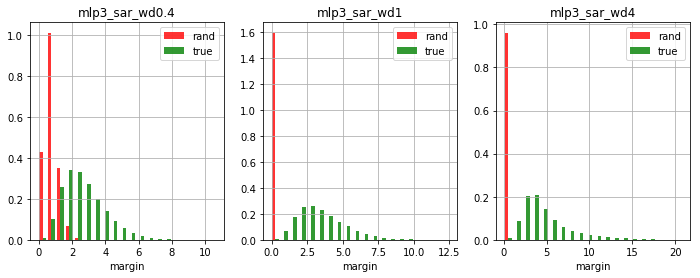

In [59]:
maindir = 'save_weights_n50000_mlp3'

arch_d = {
    'mlp3_rand': mlp.mlp3,
    'mlp3_rand_sn': mlp.mlp3_sn,
    'mlp3_rand_sar_wd0': mlp.mlp3_sar,
    'mlp3_rand_sar_wd0.04': mlp.mlp3_sar,
    'mlp3_rand_sar_wd0.4': mlp.mlp3_sar,
    'mlp3_rand_sar_wd1': mlp.mlp3_sar,
    'mlp3_rand_sar_wd4': mlp.mlp3_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand/checkpoints/epoch58
Sanity check: accuracy is 0.99968.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Sanity check: accuracy is 0.98666.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand_sar_wd0/checkpoints/epoch61
Sanity check: accuracy is 0.99858.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true_sar_wd0/checkpoints/epoch27
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand_sn/checkpoints/epoch69
Sanity check: accuracy is 0.99822.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true_sn/checkpoints/epoch30
Sanity check: accuracy is 1.00000.
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_rand_sar_wd4e-07/checkpoints/epoch61
Sanity check: accuracy is 0.99846.
INFO:tensorflow:Restoring parameters from save_weights_n

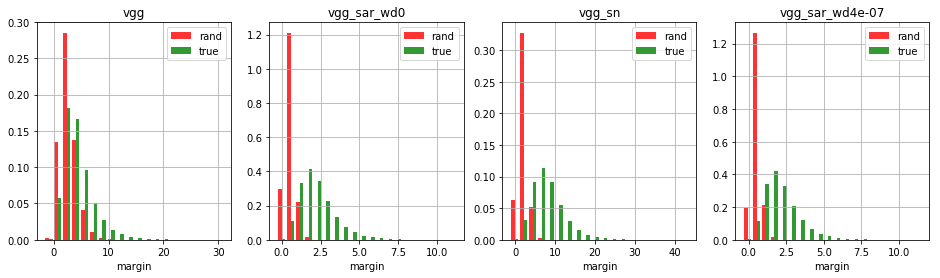

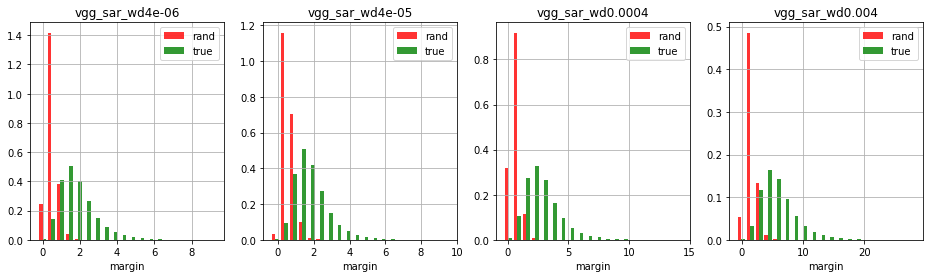

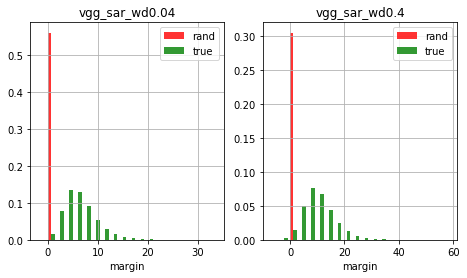

In [60]:
maindir = 'save_weights_n50000_vgg'

arch_d = {
    'vgg_rand': vgg.vgg,
    'vgg_rand_sn': vgg.vgg_sn,
    'vgg_rand_sar_wd0': vgg.vgg_sar,
    'vgg_rand_sar_wd4e-07': vgg.vgg_sar,
    'vgg_rand_sar_wd4e-06': vgg.vgg_sar,
    'vgg_rand_sar_wd4e-05': vgg.vgg_sar,
    'vgg_rand_sar_wd0.0004': vgg.vgg_sar,
    'vgg_rand_sar_wd0.004': vgg.vgg_sar,
    'vgg_rand_sar_wd0.04': vgg.vgg_sar,
    'vgg_rand_sar_wd0.4': vgg.vgg_sar,
}

make_margin_plots_for_all_in_dir(data, maindir, arch_d)

### Spectral normalization using our tighter method

# Adversarial attacks

In [33]:
from spectral_adversarial_regularization import adversarial as ad

def test_adv_for_all_in_dir(data, maindir, arch_d, plots_per_row=4):
    arch_name = maindir.split('_')[-1]
    start = time.time()

    def sort_func(fname):
        if 'wd' not in fname:
            return (0, fname)
        return (float(fname.split('wd')[1]), fname)

    rand_acc = {}
    true_acc = {}
    
    for f in sorted(os.listdir(maindir), key=sort_func):
        save_dir = os.path.join(maindir, f)

        if 'rand' in f:
            arch = arch_d[f]
            print(save_dir)
            rand_acc[save_dir] = ad.test_net_against_adv_examples(data['rand'][0], data['rand'][1], save_dir, arch=arch)
            save_dir = save_dir.replace('rand', 'true')
            print(save_dir)
            true_acc[save_dir] = ad.test_net_against_adv_examples(data['true'][0], data['true'][1], save_dir, arch=arch)
        
    return rand_acc, true_acc


def get_adv_performance(X, num_classes, load_weights, arch, Y=None):
    tf.reset_default_graph()
    graph = dl_utils.graph_builder_wrapper(num_classes, './temp/', arch=arch)

    start = time.time()
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        if isinstance(load_weights, str):
            graph['saver'].restore(sess, load_weights)
            
        elif isinstance(load_weights, dict):
            for v in tf.trainable_variables():
                sess.run(v.assign(load_weights[v.name]))
        
        else:
            print('load_weights should be either a filename to (or a dict of) values to assign weights')
        
        Yhat = dl_utils.predict_labels_in_sess(X, graph, sess)
        X_adv = ad.gen_adv_examples_in_sess(X, graph, sess)
        Yhat_adv = dl_utils.predict_labels_in_sess(X_adv, graph, sess)

    if Y is not None:
        accs = np.sum(Yhat == Y)/float(len(Y))
        accs_adv = np.sum(Yhat_adv == Y)/float(len(Y))
        print('Acc on examples: %.2f, Acc on adv examples: %.2f (%.3f s elapsed)' \
              %(accs, accs_adv, time.time()-start))

    return accs, accs_adv

In [16]:
# Alexnet architecture with weights from spectral normalization (post-normalization)
d = get_sn_weights(num_classes, 'save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25', alexnet.alexnet_sar)

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25
fc/weights:0 with sv 5.78
conv1/weights:0 with sv 1.02
linear1/weights:0 with sv 1.01
linear2/weights:0 with sv 1.02
conv2/weights:0 with sv 1.02


In [34]:
results = get_adv_performance(X, num_classes, d, arch=alexnet.alexnet, Y=Y)

Acc on examples: 1.00, Acc on adv examples: 0.03 (4.750 s elapsed)


In [81]:
arch_d = {
    'alexnet_rand': alexnet.alexnet,
    'alexnet_rand_sn': alexnet.alexnet_sn,
    'alexnet_rand_sar_wd0': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.04': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd0.4': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd1': alexnet.alexnet_sar,
    'alexnet_rand_sar_wd4': alexnet.alexnet_sar,
}

results = test_adv_for_all_in_dir(data, 'save_weights_n50000_alexnet/', arch_d)

save_weights_n50000_alexnet/alexnet_rand
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
Acc on examples: 1.00, Acc on adv examples: 0.05 (45.147 s elapsed)
save_weights_n50000_alexnet/alexnet_true
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on examples: 1.00, Acc on adv examples: 0.19 (44.813 s elapsed)
save_weights_n50000_alexnet/alexnet_rand_sar_wd0
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0/checkpoints/epoch48
Acc on examples: 1.00, Acc on adv examples: 0.00 (42.846 s elapsed)
save_weights_n50000_alexnet/alexnet_true_sar_wd0
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25
Acc on examples: 1.00, Acc on adv examples: 0.03 (39.123 s elapsed)
save_weights_n50000_alexnet/alexnet_rand_sn
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexne

In [83]:
arch_d = {
    'alexnet_rand': alexnet.alexnet,
    'alexnet_rand_sn': alexnet.alexnet,
    'alexnet_rand_sar_wd0': alexnet.alexnet,
    'alexnet_rand_sar_wd0.04': alexnet.alexnet,
    'alexnet_rand_sar_wd0.4': alexnet.alexnet,
    'alexnet_rand_sar_wd1': alexnet.alexnet,
    'alexnet_rand_sar_wd4': alexnet.alexnet,
}

results_ = test_adv_for_all_in_dir(data, 'save_weights_n50000_alexnet/', arch_d)

save_weights_n50000_alexnet/alexnet_rand
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand/checkpoints/epoch80
Acc on examples: 1.00, Acc on adv examples: 0.05 (44.195 s elapsed)
save_weights_n50000_alexnet/alexnet_true
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on examples: 1.00, Acc on adv examples: 0.19 (44.979 s elapsed)
save_weights_n50000_alexnet/alexnet_rand_sar_wd0
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_rand_sar_wd0/checkpoints/epoch48
Acc on examples: 1.00, Acc on adv examples: 0.94 (44.239 s elapsed)
save_weights_n50000_alexnet/alexnet_true_sar_wd0
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd0/checkpoints/epoch25
Acc on examples: 1.00, Acc on adv examples: 0.69 (46.136 s elapsed)
save_weights_n50000_alexnet/alexnet_rand_sn
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexne

In [ ]:
arch_d = {
    'alexnet_rand': alexnet.alexnet,
    'alexnet_rand_sn': alexnet.alexnet,
    'alexnet_rand_sar_wd0': alexnet.alexnet,
    'alexnet_rand_sar_wd0.04': alexnet.alexnet,
    'alexnet_rand_sar_wd0.4': alexnet.alexnet,
    'alexnet_rand_sar_wd1': alexnet.alexnet,
    'alexnet_rand_sar_wd4': alexnet.alexnet,
}

results_ = test_adv_for_all_in_dir(data, 'save_weights_n50000_alexnet/', arch_d)

# Checking what happens if we feedforward one network (non-sn) with weights trained on another network (sn)

4/17/18 findings:
- working with mlp.mlp1_sn
- looking at output of hidden layer (tf.add_to_collection('hidden', hidden))
- **hidden layer values change even when rerunning with the same weights**
- seems like when we load weights from the same file, they change slightly from different loadings.. 
- weights stabilize if we change update_collection=None, but hidden layer values still change
- Conclusion: It's a floating point issue..?

In [41]:
def get_embedding_and_yhat(X, num_classes, load_weights, arch, Y=None):
    tf.reset_default_graph()
    graph = dl_utils.graph_builder_wrapper(num_classes, './temp/', arch=arch, update_collection='_')

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        if isinstance(load_weights, str):
            graph['saver'].restore(sess, load_weights)
            
        elif isinstance(load_weights, dict):
            for v in tf.trainable_variables():
                sess.run(v.assign(load_weights[v.name]))
        
        else:
            print('load_weights should be either a filename to (or a dict of) values to assign weights')
        
        Yhat = dl_utils.predict_labels_in_sess(X, graph, sess)
        embedding = dl_utils.get_embedding_in_sess(X, graph, sess)
        
    if Y is not None:
        print('acc %.5f'%(np.sum(Yhat == Y)/float(len(Yhat))))

    return Yhat, embedding

# doesnt work for inception since the naming convention is different..
def get_sn_weights(num_classes, load_weights_file, arch):    

    assert 'alex' in load_weights_file or 'mlp' in load_weights_file
    
    # Grab weights from spectrally normalized version of graph
    tf.reset_default_graph()
    graph = dl_utils.graph_builder_wrapper(num_classes, './temp/', arch=arch, update_collection='_')
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        graph['saver'].restore(sess, load_weights_file)
        d = {v.name:sess.run(v) for v in tf.trainable_variables()}
        for v in tf.get_collection('w_after_sn'):
            d[v.name.split('_')[0]+':0'] = sess.run(v)

    # doublecheck singular values
    for k in d:
        if 'weights' in k:
            dim = d[k].shape[-1]
            print('%s with sv %.2f'%(k, np.linalg.svd(d[k].reshape(-1, dim))[1][0]))
            
    return d

def compare_embeddings(e1, e2):
    y1 = np.argmax(e1, 1)
    y2 = np.argmax(e2, 1)
    plt.figure(figsize=(16, 4))
    for j, i in enumerate(np.where(y1 != y2)[0][:4]):
        plt.subplot(1, 4, j+1)
        plt.plot(e1[i])
        plt.plot(e2[i])
        plt.title('%.3f%% match'%(100*np.sum(y1 == y2)/float(len(y1))))
        
def check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=False):
    
    fname1 = os.path.join(fname1, 'checkpoints', 'epoch%s'%(dl_utils.latest_epoch(fname1)))
    fname2 = os.path.join(fname2, 'checkpoints', 'epoch%s'%(dl_utils.latest_epoch(fname2)))
    
    num_classes = len(np.unique(Y))
    
    # Normal
    if not just_see_if_weights_transfer:
        y1, e1 = get_embedding_and_yhat(X, num_classes, fname1, arch1, Y=Y)
    
    # Spectral normalization
    y2, e2 = get_embedding_and_yhat(X, num_classes, fname2, arch2, Y=Y)
    
    # Normal using weights from spectral normalization (pre-normalization)
    if not just_see_if_weights_transfer:
        y3, e3 = get_embedding_and_yhat(X, num_classes, fname2, arch1, Y=Y)
    
    # Normal using weights from spectral normalization (post-normalization)
    d = get_sn_weights(num_classes, fname2, arch2)
    y4, e4 = get_embedding_and_yhat(X, num_classes, d, arch=arch1, Y=Y)
    
    return e2, e4

def get_mlp_hidden(X, num_classes, load_weights, arch):
    tf.reset_default_graph()
    
    graph = dl_utils.graph_builder_wrapper(num_classes, './temp/', arch=arch, update_collection='_')

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

        if isinstance(load_weights, str):
            graph['saver'].restore(sess, load_weights)
            
        elif isinstance(load_weights, dict):
            for v in tf.trainable_variables():
                sess.run(v.assign(load_weights[v.name]))
        
        else:
            print('load_weights should be either a filename to (or a dict of) values to assign weights')
        
        hidden = sess.run(tf.get_collection('hidden')[0],
                          feed_dict={graph['input_data']:X})
        
        debug = sess.run(tf.get_collection('debug'),
                          feed_dict={graph['input_data']:X})
        
        return hidden, debug

In [5]:
labels = 'true'
X = data[labels][0][:10000]
Y = data[labels][1][:10000]

In [6]:
# mlp1
arch_name = 'mlp1'

fname1 = 'save_weights_n50000_%s/%s_true/'%(arch_name, arch_name)
arch1 = mlp.mlp1

print('-'*80+'\nChecking for sn')
fname2 = 'save_weights_n50000_%s/%s_true_sn/'%(arch_name, arch_name)
arch2 = mlp.mlp1_sn
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

print('-'*80+'\nChecking for sar')
fname2 = 'save_weights_n50000_%s/%s_true_sar_wd1/'%(arch_name, arch_name)
arch2 = mlp.mlp1_sar
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

--------------------------------------------------------------------------------
Checking for sn
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
acc 0.85810
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
hidden/weights:0 with sv 1.04
fc/weights:0 with sv 1.03
acc 0.85810
--------------------------------------------------------------------------------
Checking for sar
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd1/checkpoints/epoch499
acc 0.49830
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sar_wd1/checkpoints/epoch499
hidden/weights:0 with sv 1.05
fc/weights:0 with sv 0.35
acc 0.49830


In [224]:
for i in range(5):
    h, debug = get_mlp_hidden(X, num_classes, fname2, mlp.mlp1_sn)
    print('%.10f'%(np.sum(np.abs(h))))
    print('%.10f'%(np.sum(np.abs(debug[0]))))
    print('%.10f'%(np.sum(np.abs(debug[1]))))

INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
3704073.5000000000
17.7747497559
18231.8945312500
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
3704073.5000000000
17.7747459412
18231.8945312500
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
3704072.7500000000
17.7747459412
18231.8945312500
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
3704072.7500000000
17.7747459412
18231.8945312500
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp1/mlp1_true_sn/checkpoints/epoch499
3704073.5000000000
17.7747497559
18231.8945312500


In [7]:
# mlp3
arch_name = 'mlp3'

fname1 = 'save_weights_n50000_%s/%s_true/'%(arch_name, arch_name)
arch1 = mlp.mlp3

print('-'*80+'\nChecking for sn')
fname2 = 'save_weights_n50000_%s/%s_true_sn/'%(arch_name, arch_name)
arch2 = mlp.mlp3_sn
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

print('-'*80+'\nChecking for sar')
fname2 = 'save_weights_n50000_%s/%s_true_sar_wd1/'%(arch_name, arch_name)
arch2 = mlp.mlp3_sar
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

--------------------------------------------------------------------------------
Checking for sn
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sn/checkpoints/epoch499
acc 0.90730
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sn/checkpoints/epoch499
fc/weights:0 with sv 1.01
hidden1/weights:0 with sv 1.04
hidden2/weights:0 with sv 1.03
hidden3/weights:0 with sv 1.01
acc 0.90730
--------------------------------------------------------------------------------
Checking for sar
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd1/checkpoints/epoch499
acc 0.50950
INFO:tensorflow:Restoring parameters from save_weights_n50000_mlp3/mlp3_true_sar_wd1/checkpoints/epoch499
fc/weights:0 with sv 0.33
hidden1/weights:0 with sv 1.02
hidden2/weights:0 with sv 1.02
hidden3/weights:0 with sv 1.02
acc 0.50950


In [8]:
# alexnet
arch_name = 'alexnet'

fname1 = 'save_weights_n50000_%s/%s_true/'%(arch_name, arch_name)
arch1 = alexnet.alexnet

print('-'*80+'\nChecking for sn')
fname2 = 'save_weights_n50000_%s/%s_true_sn/'%(arch_name, arch_name)
arch2 = alexnet.alexnet_sn
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

print('-'*80+'\nChecking for sar')
fname2 = 'save_weights_n50000_%s/%s_true_sar_wd1/'%(arch_name, arch_name)
arch2 = alexnet.alexnet_sar
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

print('-'*80+'\nChecking for tighter sn')
fname2 = 'save_weights_n50000_%s_tightsn/%s_true_sn/'%(arch_name, arch_name)
arch2 = alexnet_tightsn.alexnet_sn
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

print('-'*80+'\nChecking for tigther sar')
fname2 = 'save_weights_n50000_%s_tightsn/%s_true_sar_wd0.004/'%(arch_name, arch_name)
arch2 = alexnet_tightsn.alexnet_sar
e2, e4 = check_weights_on_two_archs(fname1, fname2, arch1, arch2, X, Y, just_see_if_weights_transfer=True)

--------------------------------------------------------------------------------
Checking for sn
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sn/checkpoints/epoch69
acc 0.99890
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sn/checkpoints/epoch69
fc/weights:0 with sv 1.02
conv1/weights:0 with sv 1.05
linear1/weights:0 with sv 1.04
linear2/weights:0 with sv 1.03
conv2/weights:0 with sv 1.05
acc 0.99890
--------------------------------------------------------------------------------
Checking for sar
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd1/checkpoints/epoch499
acc 0.89430
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true_sar_wd1/checkpoints/epoch499
fc/weights:0 with sv 0.25
conv1/weights:0 with sv 1.03
linear1/weights:0 with sv 1.04
linear2/weights:0 with sv 1.02
conv2/weights:0 with sv 1.05
acc 0.89460
-----------------------------